In [11]:
import missingno as msno
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import statistics
from plotnine import ggplot, aes, geom_density, geom_line, geom_point, ggtitle

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RepeatedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import mean_squared_error, roc_auc_score
import xgboost as xgb
from category_encoders.ordinal import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import partial_dependence
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import preprocessing

In [4]:
flights = pd.read_csv("/home/emumen/Documents/flights-price-ml/data/cleaned_data.csv")
flights.head(15)

,airline,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,month,day
0,IndiGo,Banglore,New Delhi,evening,mid_night,10200,0,No info,3897,3,24
1,Air India,Kolkata,Banglore,mid_night,afternoon,26700,2,No info,7662,5,1
2,Jet Airways,Delhi,Cochin,morning,mid_night,68400,2,No info,13882,6,9
3,IndiGo,Kolkata,Banglore,evening,evening,19500,1,No info,6218,5,12
4,IndiGo,Banglore,New Delhi,afternoon,evening,17100,1,No info,13302,3,1
5,SpiceJet,Kolkata,Banglore,morning,morning,8700,0,No info,3873,6,24
6,Jet Airways,Banglore,New Delhi,evening,morning,55800,1,In-flight meal not included,11087,3,12
7,Jet Airways,Banglore,New Delhi,morning,mid_night,75900,1,No info,22270,3,1
8,Jet Airways,Banglore,New Delhi,morning,morning,91800,1,In-flight meal not included,11087,3,12
9,Multiple carriers,Delhi,Cochin,morning,evening,28200,1,No info,8625,5,27


EDA

In [ ]:
msno.matrix(flights, labels=True, filter="bottom", sort="ascending", n=50)

In [5]:
flights.info()
flights.shape
flights.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10462 entries, 0 to 10461
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   airline          10462 non-null  object
 1   source           10462 non-null  object
 2   destination      10462 non-null  object
 3   dep_time         10462 non-null  object
 4   arrival_time     10462 non-null  object
 5   duration         10462 non-null  int64 
 6   total_stops      10462 non-null  int64 
 7   additional_info  10462 non-null  object
 8   price            10462 non-null  int64 
 9   month            10462 non-null  int64 
 10  day              10462 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 899.2+ KB


Index(['airline', 'source', 'destination', 'dep_time', 'arrival_time',
       'duration', 'total_stops', 'additional_info', 'price', 'month', 'day'],
      dtype='object')

In [6]:
flights.describe()

,duration,total_stops,price,month,day
count,10462.000000,10462.000000,10462.000000,10462.000000,10462.000000
mean,37786.895431,0.802332,9026.790289,4.701491,13.463200
std,30041.942724,0.660609,4624.849541,1.163802,8.467493
min,300.000000,0.000000,1759.000000,3.000000,1.000000
25%,10200.000000,0.000000,5224.000000,3.000000,6.000000
50%,30300.000000,1.000000,8266.000000,5.000000,12.000000
75%,54600.000000,1.000000,12344.750000,6.000000,21.000000
max,171600.000000,4.000000,79512.000000,6.000000,27.000000


In [16]:
flights.isnull().sum()

airline            0
source             0
destination        0
dep_time           0
arrival_time       0
duration           0
total_stops        0
additional_info    0
price              0
month              0
day                0
dtype: int64

In [7]:
#Checking out the different airlines and counting flights for each.
flights['airline'].value_counts()

Jet Airways                          3700
IndiGo                               2043
Air India                            1694
Multiple carriers                    1196
SpiceJet                              815
Vistara                               478
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: airline, dtype: int64

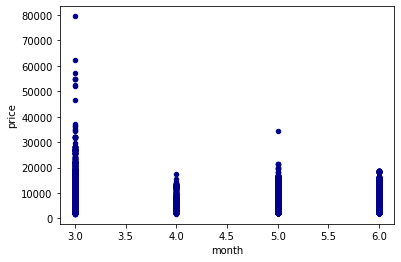

In [29]:

#Flight prices throughout the year
ax1 = flights.plot.scatter(x='month',
                           y='price',
                           c='DarkBlue')
#plt.plot(flights['month'], flights['price'])

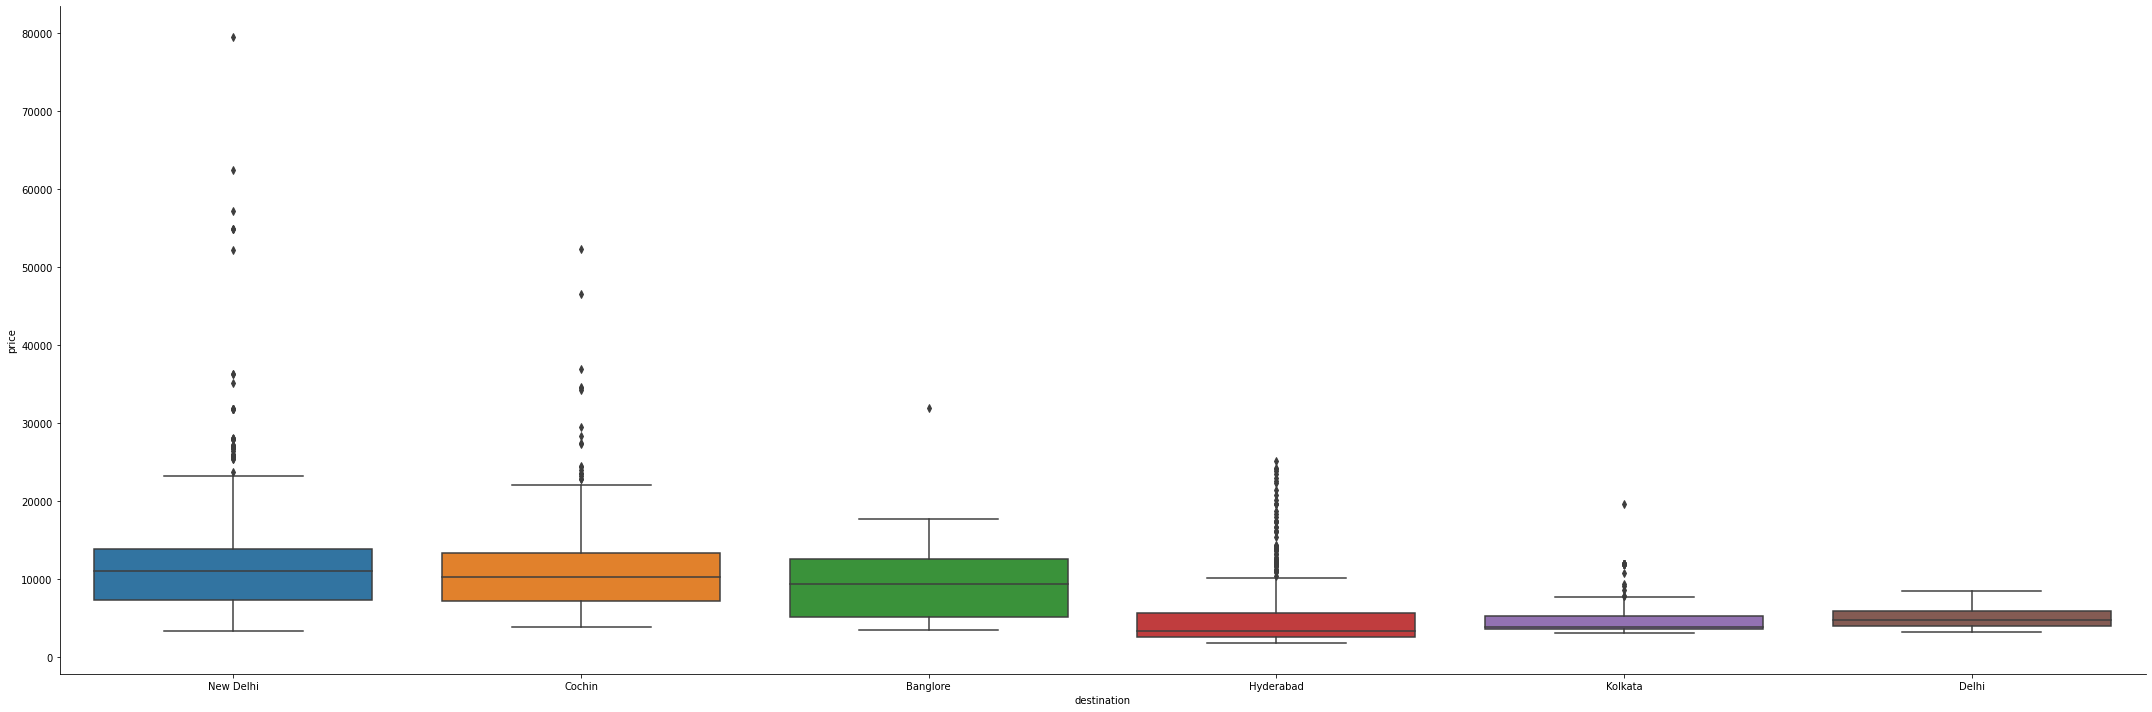

In [21]:
#A boxplot representing the prices for each destination
sns.catplot(y = "price", x = "destination", data = flights.sort_values("price", ascending = False), kind="box", height = 10, aspect = 3)
plt.show()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

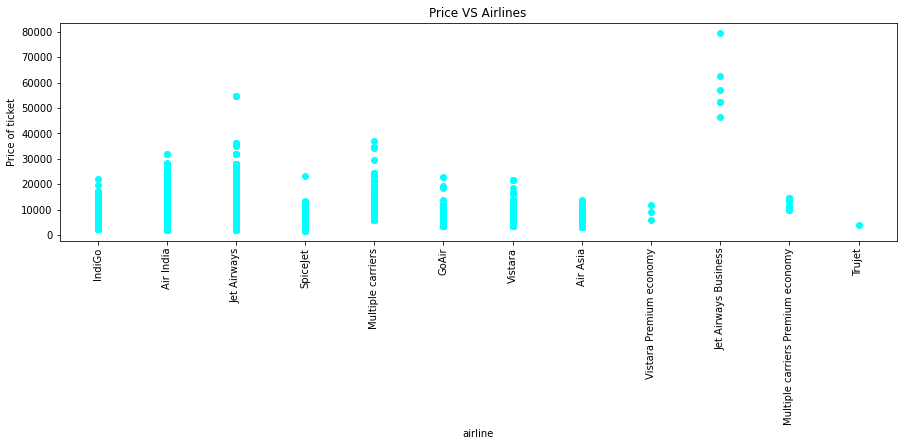

In [28]:
#Comparing prices for each airline
plt.figure(figsize = (15,4))
plt.title('Price VS Airlines')
plt.scatter(flights['airline'], flights['price'], color="cyan")
plt.xticks
plt.xlabel('airline')
plt.ylabel('Price of ticket')
plt.xticks(rotation = 90)

In [14]:
# features
flights.drop("price", axis=1).head()

,airline,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,month,day
0,IndiGo,Banglore,New Delhi,evening,mid_night,10200,0,No info,3,24
1,Air India,Kolkata,Banglore,mid_night,afternoon,26700,2,No info,5,1
2,Jet Airways,Delhi,Cochin,morning,mid_night,68400,2,No info,6,9
3,IndiGo,Kolkata,Banglore,evening,evening,19500,1,No info,5,12
4,IndiGo,Banglore,New Delhi,afternoon,evening,17100,1,No info,3,1


In [16]:
flights["price"].head()

0     3897
1     7662
2    13882
3     6218
4    13302
Name: price, dtype: int64

Gradient Boosting Model

In [5]:
#Splitting the data

train, test = train_test_split(flights, train_size=0.7, random_state=123)
train.shape

(7323, 11)

In [6]:
#This is to separate the features or attribute from the target
X_train = train.drop("price", axis=1)
y_train = train[["price"]]

In [14]:
# Ordinal encode our quality-based features 
ord_cols = list(X_train.filter(regex=("Qual$|QC$|Cond$")).columns)
lvs = ["Very_Poor", "Poor", "Fair", "Below_Average", "Average", "Typical", 
       "Above_Average", "Good", "Very_Good", "Excellent", "Very_Excellent"]
val = range(0, len(lvs))
lvl_map = dict(zip(lvs, val))
category_mapping = [{'col': col, 'mapping': lvl_map} for col in ord_cols]
ord_encoder = OrdinalEncoder(cols=ord_cols, mapping=category_mapping)

# One hot encode remaining nominal features
encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

# Combine into a pre-processing pipeline
preprocessor = ColumnTransformer(
  remainder="passthrough",
  transformers=[
   ("ord_encode", ord_encoder, ord_cols),
   ("one-hot", encoder, selector(dtype_include="object")),
   ]
  )

In [15]:
# GBM Estimator Model Object
xgb_mod = xgb.XGBRegressor()

#Loss Function
loss = 'neg_root_mean_squared_error'

#Creating a pipeline
model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("xgb_mod", xgb_mod),
])


kfold = KFold(n_splits=5, random_state=123, shuffle=True)

# Implementing a five fold CV
results = cross_val_score(model_pipeline, X_train, y_train, cv=kfold, scoring=loss)

np.abs(np.mean(results))

1740.4516144090207

In [16]:
# Setting the Hyperparameters
hyper_grid = {
  'xgb_mod__n_estimators': [1000, 2500, 5000],
  'xgb_mod__learning_rate': [0.001, 0.01, 0.1],
  'xgb_mod__max_depth': [3, 5, 7, 9],
  'xgb_mod__min_child_weight': [1, 5, 15] 
}

# create random search object
random_search = RandomizedSearchCV(
    model_pipeline, 
    param_distributions=hyper_grid, 
    n_iter=20, 
    cv=kfold, 
    scoring=loss, 
    n_jobs=-1, 
    random_state=13
)

# Execute random search
random_search_results = random_search.fit(X_train, y_train)

# Best model score
np.abs(random_search_results.best_score_)


/home/emumen/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


1580.7852672359247

In [18]:
# Best hyperparameter values
random_search_results.best_params_


{'xgb_mod__n_estimators': 2500,
 'xgb_mod__min_child_weight': 1,
 'xgb_mod__max_depth': 9,
 'xgb_mod__learning_rate': 0.01}

Feature Interpretation

In [19]:
# preprocess training data
X_encoded = preprocessor.fit_transform(X_train)

# create final model object
final_model = xgb.XGBRegressor(
    n_estimators=5000,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=1,
    subsample=1,
    colsample_bytree=0.75,
    colsample_bylevel=0.75,
    colsample_bynode=0.75
)

final_model_fit = final_model.fit(X_encoded, y_train)

# extract feature importances
vi = pd.DataFrame({'feature': preprocessor.get_feature_names(),
                   'importance': final_model_fit.feature_importances_})

# get top 20 influential features
top_20_features = vi.nlargest(20, 'importance')

# plot feature importance
(ggplot(top_20_features, aes(x='importance', y='reorder(feature, importance)'))
 + geom_point()
 + labs(y=None))

/home/emumen/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


NameError: name 'labs' is not defined